## NN Base

### Final Result

Test Set RMSE:33.53

Whole Grid Rmse:35.25514

### Data Preparation

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
#import hvplot.xarray
import sys

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

sys.path.insert(0, '../../src')

from utils import df_to_xarray,read_xarray

In [3]:
# Reading Data
dir_name="../../data/member_001"

chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2=read_xarray(dir_name)

mld=mld.isel(bnds=0)
sss=sss.isel(bnds=0)
sst=sst.isel(bnds=0)
xco2=xco2.isel(bnds=0)


mld['time'] =mld.time.indexes['time'].to_datetimeindex()
sss['time'] =sss.time.indexes['time'].to_datetimeindex()
sst['time'] =sst.time.indexes['time'].to_datetimeindex()
xco2['time'] =xco2.time.indexes['time'].to_datetimeindex()


pco2['time'] = pco2.time.dt.strftime("%Y-%m")
chl['time'] = chl.time.dt.strftime("%Y-%m")
mld['time'] =mld.time.dt.strftime("%Y-%m")
sss['time'] =sss.time.dt.strftime("%Y-%m")
sst['time'] =sst.time.dt.strftime("%Y-%m")
xco2['time'] =xco2.time.dt.strftime("%Y-%m")


data_read=xr.merge([chl.Chl,chl.Chl_socat,mld.MLD,mld.MLD_socat,sst.SST,sst.SST_socat,sss.SSS,sss.SSS_socat,xco2,pco2.pCO2,pco2.pCO2_socat])

tmp_data=data_read.to_dataframe().reset_index()
tmp_data=tmp_data.drop(columns=['TLONG', 'TLAT', 'time_bnds'])

check=tmp_data.set_index(["time","ylat","xlon"]).to_xarray()

tmp_data_final=tmp_data[tmp_data.time != "1982-01"]
tmp_data_final=tmp_data_final[tmp_data_final.time != "2017-02"]

features_socat = ['time','xlon', 'ylat','MLD_socat', 'SST_socat', 'SSS_socat','Chl_socat', 'XCO2','pCO2_socat']
features = ['time','xlon', 'ylat','MLD','SST','SSS','Chl','XCO2','pCO2']

# create separate dataframe for socat
combined_socat=tmp_data_final[features_socat]
combined=tmp_data_final[features]

combined_socat.dropna(subset = ["pCO2_socat"],inplace=True)
combined_socat= combined_socat[combined_socat['pCO2_socat']!=0]

combined.dropna(subset = ["pCO2"],inplace=True)
combined= combined[combined['pCO2']!=0]

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/tmp/ipykernel_989907/132348747.py:12: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  mld['time'] =mld.time.indexes['time'].to_datetimeindex()
/tmp/ipykernel_989907/132348747.py:13: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  sss['time'] =sss.time.indexes['time'].to_datetimeindex()


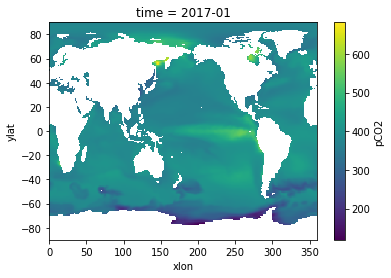

In [4]:
check.pCO2[420].plot()

In [5]:
X_socat=combined_socat.iloc[:,3:-1]
X=combined.iloc[:,3:-1]
y=combined.loc[:,'pCO2']
y_socat=combined_socat.loc[:,'pCO2_socat']


In [13]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
    ])

In [14]:
X_socat=num_pipeline.fit_transform(X_socat)
X=num_pipeline.fit_transform(X)

In [15]:
def FFN_Model():
    model = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu, kernel_initializer='glorot_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation=tf.nn.relu, kernel_initializer='glorot_normal'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, kernel_initializer='normal')])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
    
    return model

In [16]:
X_socat_train, X_socat_test, y_socat_train, y_socat_test = train_test_split(
    X_socat, y_socat, test_size=0.3, random_state= 73)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state= 73)


In [19]:
model_path = '../../models/Simple_NN_Full.h5'

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint] 

In [26]:
n_epochs = 50

model = FFN_Model()
history = model.fit(X_socat_train, y_socat_train, epochs=n_epochs, 
                    batch_size=2056, validation_data=(X_socat_test, y_socat_test),callbacks=callbacks)

Epoch 1/50
84/84 [==============================] - 3s 30ms/step - loss: 100135.0205 - mse: 100135.0205 - val_loss: 2155377.2500 - val_mse: 2155377.2500
Epoch 2/50
84/84 [==============================] - 2s 29ms/step - loss: 2842.5236 - mse: 2842.5236 - val_loss: 85002.0391 - val_mse: 85002.0391
Epoch 3/50
84/84 [==============================] - 2s 29ms/step - loss: 1968.4366 - mse: 1968.4366 - val_loss: 6348.0195 - val_mse: 6348.0195
Epoch 4/50
84/84 [==============================] - 2s 30ms/step - loss: 1756.0748 - mse: 1756.0748 - val_loss: 1865.1749 - val_mse: 1865.1749
Epoch 5/50
84/84 [==============================] - 3s 30ms/step - loss: 1630.1078 - mse: 1630.1078 - val_loss: 1517.9393 - val_mse: 1517.9393
Epoch 6/50
84/84 [==============================] - 2s 30ms/step - loss: 1580.6675 - mse: 1580.6675 - val_loss: 1420.6201 - val_mse: 1420.6201
Epoch 7/50
84/84 [==============================] - 2s 29ms/step - loss: 1504.9751 - mse: 1504.9751 - val_loss: 1383.9885 - val_ms

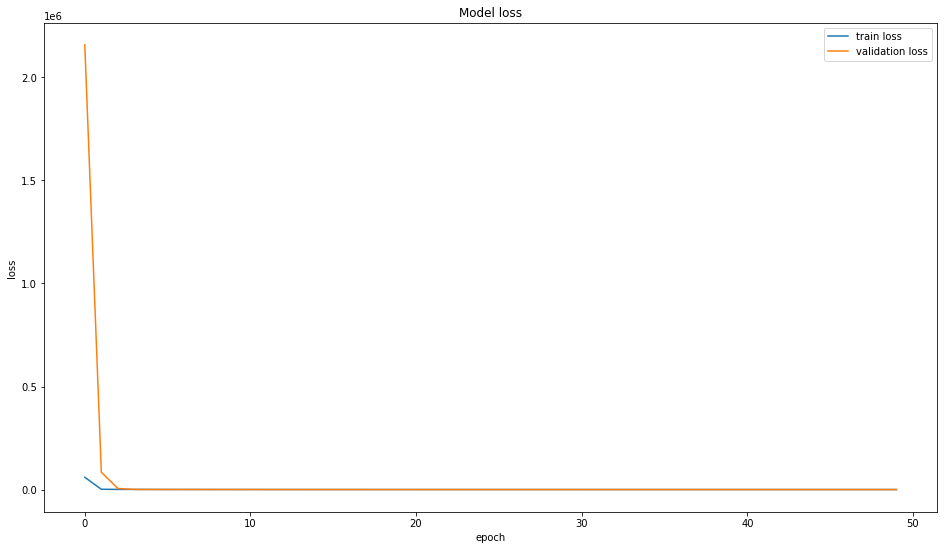

In [27]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show() 

### Prediction On Full

In [28]:
y_hat=model.predict(X,verbose=1)

539044/539044 [==============================] - 286s 530us/step


In [29]:
final_test_rmse=np.sqrt(mean_squared_error(y, y_hat,squared=True))


In [30]:
final_test_rmse

35.25514041569371